# Pathfinding using Q-learning method

In this scenario, I will use the q-learning method to teach warehouse robots to find the best path between a location in the warehouse and the drop-off location. I will also discuss congestion problems that may arise from every robot taking the same optimal path.
This project is inspired by [this tutorial](https://youtu.be/iKdlKYG78j4).


## What is Q-Learning?
- Q-learning is a type of reinforcement learning method. It involves states(map), actions (input), and rewards (output).
- Q-learning does not involve probabilistic models. Instead, it creates the optimal policy via trial and error.

## Q-value
- The Q-value indicates the quality of the action in a given state.
- A higher Q-value means more reward.
- Every combination of state and action has a Q-value associated with it. This information is stored in a Q-table (policy).
- The states and the actions must be finite.

## Temporal Difference
<img src='https://github.com/Juhyung8371/AI-ML-CV-Projects/blob/main/Artificial%20Intelligence/Reinforcement%20Learning/Q-Learning/Warehouse%20Navigation/Temporal%20Difference.png?raw=true' width=600>

[image source](https://youtu.be/__t2XRxXGxI)

- The temporal difference is a method of considering current rewards in evaluating past actions.

<img src='https://github.com/Juhyung8371/AI-ML-CV-Projects/blob/main/Artificial%20Intelligence/Reinforcement%20Learning/Q-Learning/Warehouse%20Navigation/Bellman%20Equation.png?raw=true' width=600>

[image source](https://youtu.be/__t2XRxXGxI)

- Then, we can use the Bellman Equation to update the Q-value

## Define the environment

States: 11 x 11 grid

Actions: up, right, down, and left

Each cell in the grid is either a wall, a road, or the goal. The environmental feedback is the following:

1. a penalty for traveling through the wall
2. a penalty for not taking the best path
3. a reward for reaching the goal

In [1026]:
import numpy as np

In [1027]:
#define the shape of the environment (i.e., its states).
#11x11 grid
environment_rows = 11
environment_columns = 11

#Create a 3D numpy array to hold the current Q-values for each
#state and action pair: Q(s, a)
q_values = np.zeros((environment_rows, environment_columns, 4))

In [1028]:
#define actions
actions = ['up', 'right', 'down', 'left']

In [1029]:
# default rewards for each block type

# a penalty for traveling through the wall
wall = -100.
# a penalty for not taking the best path
road = -1.
# a reward for reaching the goal
goal = 50.

In [1030]:
#Create a 2D numpy array to hold the rewards for each state.
rewards = np.full((environment_rows, environment_columns), wall)

rewards[0, 5] = goal #set the reward for the goal

#define aisle locations for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[9] = [i for i in range(11)]

#set the rewards for all aisle locations
for row_index in range(1, environment_columns-1):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = road

#print rewards matrix
print(rewards)

[[-100. -100. -100. -100. -100.   50. -100. -100. -100. -100. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
 [-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
 [-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
 [-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]]


## Define utilty functions

In [1031]:
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  block = rewards[current_row_index, current_column_index]
  return block == wall or block == goal

In [1032]:
#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  current_row_index = np.random.randint(environment_rows)
  current_column_index = np.random.randint(environment_columns)

  #continue choosing random row and column indexes until a non-terminal state is identified
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)

  return current_row_index, current_column_index

In [1033]:
#define an epsilon greedy algorithm that will choose which action to take next
def get_next_action_index(current_row_index, current_column_index, epsilon):
  # choosing a random action can introduce variance
  # which can help the agent escape a local optima
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else:
    return np.random.randint(4)

In [1034]:
#define a function that will get the next location based on the chosen action
#a.k.a. collision testing
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

In [1035]:
# Define a function that will get the shortest path between
# any 'legal' starting location and the item packaging location.
def get_shortest_path(start_row_index, start_column_index):
  #exit immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action_index(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

## Training

In [1036]:

# learning_rate: the rate at which the AI agent should learn
# discount_factor: higher value means the future rewards means more than current rewards
# epsilon: the percentage of time when we should take the best action (instead of a random action)
def train(learning_rate=0.9, discount_factor=0.9, epsilon=0.7, reset_q=True):

  if reset_q:
    global q_values
    q_values = np.zeros((environment_rows, environment_columns, 4))

  #run through 10000 training episodes
  for episode in range(10000):
    #get the starting location for this episode
    row_index, column_index = get_starting_location()

    #continue taking actions (i.e., moving) until we reach a terminal state
    #(i.e., until we reach the item packaging area or crash into an item storage location)
    while not is_terminal_state(row_index, column_index):
      #choose which action to take (i.e., where to move next)
      action_index = get_next_action_index(row_index, column_index, epsilon)

      #perform the chosen action, and transition to the next state (i.e., move to the next location)
      old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
      row_index, column_index = get_next_location(row_index, column_index, action_index)

      #receive the reward for moving to the new state, and calculate the temporal difference
      reward = rewards[row_index, column_index]
      old_q_value = q_values[old_row_index, old_column_index, action_index]
      temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

      #update the Q-value for the previous state and action pair using the Bellman Equation
      new_q_value = old_q_value + (learning_rate * temporal_difference)
      q_values[old_row_index, old_column_index, action_index] = new_q_value

  print('Training complete!')

In [1037]:
train()

Training complete!


## Result

In [1038]:
print(get_shortest_path(3, 9)) #starting at row 3, column 9
print(get_shortest_path(5, 0)) #starting at row 5, column 0
print(get_shortest_path(9, 5)) #starting at row 9, column 5

[[3, 9], [2, 9], [1, 9], [1, 8], [1, 7], [1, 6], [1, 5], [0, 5]]
[[5, 0], [5, 1], [5, 2], [5, 3], [4, 3], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]
[[9, 5], [9, 4], [9, 3], [8, 3], [7, 3], [7, 4], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]


In [1039]:
from google.colab.patches import cv2_imshow

# visualize the map and the path for easier interpretation of the path
def make_map(rewardmap, path):
  upsize_factor = 30
  rows, columns = rewardmap.shape
  map_img = np.full((environment_rows*upsize_factor, environment_columns*upsize_factor, 3), 255, dtype=np.uint8)

  for r in range(0, rows):
    for c in range(0, columns):
      current_block = rewardmap[r][c]

      wid = upsize_factor
      hei = upsize_factor
      color = -1
      draw_r = r * upsize_factor
      draw_c = c * upsize_factor

      if current_block == wall:
        color = 0
      elif current_block == goal:
        color = 150
      else:
        color = 255

      if color != -1:
        for y in range(0, upsize_factor):
          for x in range(0, upsize_factor):
            map_img[draw_r+y][draw_c+x] = [color, color, color]

      index_remove = -1

      for i, coord in enumerate(path):
        if coord == [r, c]:
          index_remove = i
          move = int(float(upsize_factor) / 4.)
          half = int(float(upsize_factor) / 2.)
          for y in range(0, half):
            for x in range(0, half):
              map_img[draw_r+y+move][draw_c+x+move] = [255, 0, 0]

      if index_remove != -1:
        del path[index_remove]

  return map_img

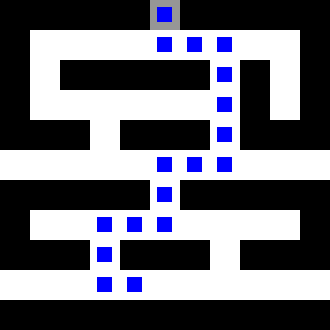

In [1040]:
cv2_imshow(make_map(rewards, get_shortest_path(9, 4)))

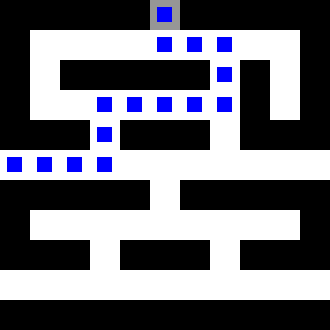

In [1041]:
cv2_imshow(make_map(rewards, get_shortest_path(5, 0)))

## Congestion Problem

There is more than one robot working in a warehouse. If every robot takes the same optimal path, then that will cause a congestion problem. I will alleviate that issue by analyzing the road usage rate and adjusting the reward of each road based on its usage rate. For example, robots will be rewarded for using longer but less used roads.

In [1042]:
def get_road_usage(rewardmap):

  # list of all paths
  all_paths = []

  rows, columns = rewardmap.shape
  for r in range(0, rows):
    for c in range(0, columns):
      current_block = rewardmap[r][c]
      if current_block != wall and current_block != goal:
        current_path = get_shortest_path(r, c)
        all_paths.append(current_path)

  freq = np.zeros((environment_rows, environment_columns), dtype=np.uint8)

  for path in all_paths:
    for block in path:
      block_row = block[0]
      block_col = block[1]
      freq[block_row][block_col] += 1

  return freq

In [1043]:
freq1 = get_road_usage(rewards)
print(freq1)

[[ 0  0  0  0  0 56  0  0  0  0  0]
 [ 0  4  5  6  7 56 48 47  4  3  0]
 [ 0  3  0  0  0  0  0 42  0  2  0]
 [ 0  2  1  6  7  8  9 41  0  1  0]
 [ 0  0  0  5  0  0  0 31  0  0  0]
 [ 1  2  3  4  1 25 26 30  3  2  1]
 [ 0  0  0  0  0 23  0  0  0  0  0]
 [ 0  1  2 10 11 22 10  9  2  1  0]
 [ 0  0  0  7  0  0  0  6  0  0  0]
 [ 1  2  3  6  2  1  1  5  3  2  1]
 [ 0  0  0  0  0  0  0  0  0  0  0]]


Visualize the usage

In [1044]:
def usage_to_image(usage_map):

  rows1, columns1 = usage_map.shape

  reshaped = usage_map.reshape(rows1*columns1)

  the_min = 0
  the_max = max(reshaped)

  freq_copy = usage_map.copy()

  for r in range(0, rows1):
    for c in range(0, columns1):
      freq_copy[r][c] = (usage_map[r][c] - the_min) * 255 / (the_max- the_min)

  return freq_copy

In [1045]:
import cv2

We can see how that right path is overused. We want to divert some of it to the left path.

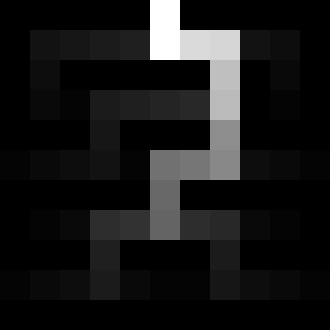

In [1046]:
freq_map1 = cv2.resize(usage_to_image(freq1), (0, 0), fx = 30, fy = 30, interpolation = cv2.INTER_AREA)
cv2_imshow(freq_map1)

Update rewards and train again.

In [1047]:
rows, columns = rewards.shape
for r in range(0, rows):
  for c in range(0, columns):
    rewards[r][c] -= int(freq1[r][c] * 0.05)

rewards[0, 5] = goal

print(rewards)

[[-100. -100. -100. -100. -100.   50. -100. -100. -100. -100. -100.]
 [-100.   -1.   -1.   -1.   -1.   -3.   -3.   -3.   -1.   -1. -100.]
 [-100.   -1. -100. -100. -100. -100. -100.   -3. -100.   -1. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -3. -100.   -1. -100.]
 [-100. -100. -100.   -1. -100. -100. -100.   -2. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -2.   -2.   -2.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100.   -2. -100. -100. -100. -100. -100.]
 [-100.   -1.   -1.   -1.   -1.   -2.   -1.   -1.   -1.   -1. -100.]
 [-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]]


In [1048]:
train()

Training complete!


### Result and comparison


After adjusting the rewards, the right path's usage decreases up to 8, and that is transferred to the left path. This can alleviate some congestion problems in the right path.

In [1049]:
print('Before:\n')
print(freq1)

print('\n After:\n')
freq2 = get_road_usage(rewards)
print(freq2)

print('\n Difference:\n')

rows, columns = rewards.shape
diff = np.zeros((rows, columns))

for r in range(0, rows):
  for c in range(0, columns):
    diff[r][c] = int(freq2[r][c]) - int(freq1[r][c])

print(diff)

Before:

[[ 0  0  0  0  0 56  0  0  0  0  0]
 [ 0  4  5  6  7 56 48 47  4  3  0]
 [ 0  3  0  0  0  0  0 42  0  2  0]
 [ 0  2  1  6  7  8  9 41  0  1  0]
 [ 0  0  0  5  0  0  0 31  0  0  0]
 [ 1  2  3  4  1 25 26 30  3  2  1]
 [ 0  0  0  0  0 23  0  0  0  0  0]
 [ 0  1  2 10 11 22 10  9  2  1  0]
 [ 0  0  0  7  0  0  0  6  0  0  0]
 [ 1  2  3  6  2  1  1  5  3  2  1]
 [ 0  0  0  0  0  0  0  0  0  0  0]]

 After:

[[ 0  0  0  0  0 56  0  0  0  0  0]
 [ 0 12 13 14 15 56 40 39  4  3  0]
 [ 0 11  0  0  0  0  0 34  0  2  0]
 [ 0 10  9  8  1  1  2 33  0  1  0]
 [ 0  0  0  6  0  0  0 30  0  0  0]
 [ 1  2  3  5  1 24 25 29  3  2  1]
 [ 0  0  0  0  0 23  0  0  0  0  0]
 [ 0  1  2 10 11 22 10  9  2  1  0]
 [ 0  0  0  7  0  0  0  6  0  0  0]
 [ 1  2  3  6  2  1  1  5  3  2  1]
 [ 0  0  0  0  0  0  0  0  0  0  0]]

 Difference:

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  8.  8.  8.  8.  0. -8. -8.  0.  0.  0.]
 [ 0.  8.  0.  0.  0.  0.  0. -8.  0.  0.  0.]
 [ 0.  8.  8.  2. -6. -7. -7. -

Visualize the usage before and after

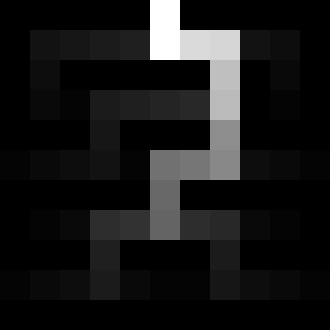

In [1050]:
cv2_imshow(freq_map1)

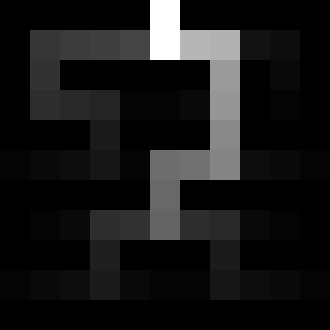

In [1051]:
freq_map2 = cv2.resize(usage_to_image(freq2), (0, 0), fx = 30, fy = 30, interpolation = cv2.INTER_AREA)
cv2_imshow(freq_map2)

Now, the robot is more likely to take the left path compared to before.

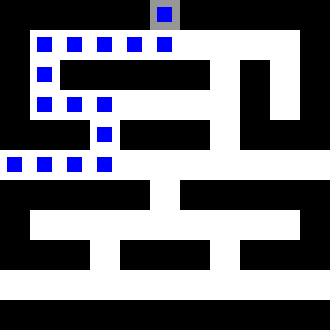

In [1053]:
cv2_imshow(make_map(rewards, get_shortest_path(5, 0)))